# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#Methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The problem I have chosen to analyse involves the decision regarding where to open a gym in Manhattan, New York City , USA. There are several factors which will play a role in determining this optimal location. The gym needs to be centrally located and needs to be easily accessible from all parts of the city. 

The gym should also have complementary venues near it. For example, the presence of a spa nearby will encourage customers to purchase gym membership of said gym. The gym should also not exist in a place where several gyms already exist which would generate unnecessary competition. Clusters will be generated to assess each neighborhood. 

I will attempt to generate a list of neighbourhoods most suitable which will result in maximum revenue for the stakeholder wishing to set up the gym. 


## Data <a name="data"></a>

Based on the factors I discussed above, the following data will be required:
*	The distance of each neighbourhood from the centre of the city.
*	The venues nearby which are complementary to the gym.
*	The number of gyms that exist in each neighbourhood.

The neighbourhoods have been identified from the source: https://cocl.us/new_york_dataset. All the features will be extracted from this data source.
The other data will be extracted using the Foursquare API. The location of each neighbourhood will be obtained from the GeoPy GeoCoder package in Python.


## Methodology <a name="Methodology"></a>

The steps involved in the conduction of this project and the efficient detection of suitable neighborhoods in which to establish a gym:
* The first step involves obtaining the data in the appropriate format
* I obtained the **latitude and longitude** of all these neighborhoods in New York City
* I then focused my attention to Manhattan Borough and plotted its neighborhoods using Folium.
* I fixed the center of the city as **Central Park** to maintain a reference point
* The **distance** of each neighborhood from the center was calculated using GeoPy.
* Only those neighborhoods were shortlisted which were **less than 5 Kms from the centre**.This gave me **21 neighborhoods** to work with.
* Obtained the venues in each neighborhood's vicinity which gave me approximately **1500 locations**. This was done by sending **get requests to Foursquare API**.
* I obtained the **top 5 most common venues** categories for each neighborhood.
* I then obtained a dataframe which shows the number of gyms within 500m each neighborhood.
* **KNN algorithm was applied to this dataset** to sort the neighborhoods into **5 clusters**.
* Each cluster was analyzed to assess its characteristics
* I then plotted a **barchart** using seaborn to showcase the **potential of each neighborhood** when it comes to establishing a Gym.

### Import all required packages

In [1]:
import numpy as np #import the required packages and libraries
import pandas as pd
import folium
import json
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
print("done")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
don

### Download the dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data: #Loading the json file
    newyork_data = json.load(json_data)

### Explore the dataset

In [4]:
neighborhoods_data = newyork_data['features'] #extracting the features only for our analysis

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

In [6]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] #Construction of the DataFrame

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
neighborhoods #Checking if the Dataframe is correct

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    Borough=data['properties']['borough']
    Neighborhood=data['properties']['name']
    Longitude=data['properties']['bbox'][1]
    Latitude=data['properties']['bbox'][0]
    neighborhoods = neighborhoods.append({'Borough': Borough,
                                          'Neighborhood': Neighborhood,
                                          'Longitude': Latitude,
                                          'Latitude': Longitude}, ignore_index=True)  

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
map_newyork    


let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualize Manhattan the neighborhoods in it.

In [14]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Let us obtain the distance of each neighborhood from the center of Manhattan i.e. Central Park

In [57]:
from geopy.distance import geodesic 
centre_nyc=[40.785091, -73.968285] #I have chosen Central Park as the centre of the city.
list=[]
for i in range(manhattan_data.shape[0]):
    lat=manhattan_data.iloc[i][2]
    long=manhattan_data.iloc[i][3]
    list.append(geodesic((lat,long),centre_nyc).km) # Calculation of the distcance from the centre

Lets append this list to our dataset

In [58]:
manhattan_data['Distance from Centre']=list

In [59]:
manhattan_data.sort_values(by='Distance from Centre',ascending=True,inplace=True)


Lets remove the area that are at a distance greater than 5 kms from the center

In [60]:
final_data=manhattan_data[manhattan_data['Distance from Centre']<=5] #Remove all area at a greater distance from the centre of NYC.

In [64]:
final_data.head()

,Borough,Neighborhood,Latitude,Longitude,Distance from Centre
12,Manhattan,Upper West Side,40.787658,-73.977059,0.793568
8,Manhattan,Upper East Side,40.775639,-73.960508,1.238088
30,Manhattan,Carnegie Hill,40.782683,-73.953256,1.296437
25,Manhattan,Manhattan Valley,40.797307,-73.964286,1.397942
13,Manhattan,Lincoln Square,40.773529,-73.985338,1.928930


Let us view the shortlisted neighborhoods 

In [20]:
map_manhattan1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(final_data['Latitude'], final_data['Longitude'], final_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan1)  
    
map_manhattan1

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [30]:
CLIENT_ID = 'UVE2AXEQRFTQCRSIJ2DHOT3CFZRRB3AXVUYFFASA4XO0OEKQ' # your Foursquare ID
CLIENT_SECRET = 'JKCMAZGWTTBLZXR04P5FLXLDDQHSFV0CAAL0FYQLGJZ4CBNG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UVE2AXEQRFTQCRSIJ2DHOT3CFZRRB3AXVUYFFASA4XO0OEKQ
CLIENT_SECRET:JKCMAZGWTTBLZXR04P5FLXLDDQHSFV0CAAL0FYQLGJZ4CBNG


In [31]:
LIMIT=100
radius=500

The function below gives the 100 nearest venues within 500m for each neighborhood

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:


manhattan_venues = getNearbyVenues(names=final_data['Neighborhood'],
                                   latitudes=final_data['Latitude'],
                                   longitudes=final_data['Longitude']
                                  )

Upper West Side
Upper East Side
Carnegie Hill
Manhattan Valley
Lincoln Square
Lenox Hill
Yorkville
East Harlem
Morningside Heights
Sutton Place
Roosevelt Island
Midtown
Manhattanville
Turtle Bay
Clinton
Central Harlem
Hudson Yards
Murray Hill
Tudor City
Midtown South
Hamilton Heights


In [32]:
manhattan_venues.shape

(1502, 7)

In [27]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 248 uniques categories.


## Analysis <a name="analysis"></a>

The first step is to get a count of the number of gyms in the vicinity of each neighborhood

In [35]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

x=manhattan_onehot[manhattan_onehot['Gym']>0]
df=x.loc[:,['Gym','Neighborhood']]
df.reset_index()
y=df.groupby('Neighborhood').sum()
y.sort_values(by='Gym',ascending=False,inplace=True)
y

,Gym
Neighborhood,
Yorkville,5
Clinton,4
Carnegie Hill,3
Lenox Hill,3
Hudson Yards,2
Lincoln Square,2
Midtown,2
Sutton Place,2
Tudor City,2


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

#### Let's print each neighborhood along with the top 5 most common venues

In [36]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Carnegie Hill----
                 venue  freq
0          Coffee Shop  0.09
1               Bakery  0.03
2  Japanese Restaurant  0.03
3        Grocery Store  0.03
4                  Gym  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1  American Restaurant  0.05
2   Seafood Restaurant  0.05
3   Chinese Restaurant  0.05
4    French Restaurant  0.05


----Clinton----
                  venue  freq
0               Theater  0.08
1  Gym / Fitness Center  0.05
2           Coffee Shop  0.05
3             Wine Shop  0.04
4                 Hotel  0.04


----East Harlem----
                       venue  freq
0         Mexican Restaurant  0.14
1                     Bakery  0.09
2            Thai Restaurant  0.07
3  Latin American Restaurant  0.05
4              Deli / Bodega  0.05


----Hamilton Heights----
                venue  freq
0         Pizza Place  0.10
1       Deli / Bodega  0.07
2         Coffee Shop  0.07
3                Café  0.07
4  Mexic

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [79]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Carnegie Hill,Coffee Shop,Yoga Studio,Bakery,Bookstore,Grocery Store
1,Central Harlem,African Restaurant,Cosmetics Shop,Bar,Seafood Restaurant,French Restaurant
2,Clinton,Theater,Gym / Fitness Center,Coffee Shop,Gym,Wine Shop
3,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Deli / Bodega
4,Hamilton Heights,Pizza Place,Café,Deli / Bodega,Coffee Shop,Mexican Restaurant
5,Hudson Yards,Italian Restaurant,Gym / Fitness Center,American Restaurant,Hotel,Park
6,Lenox Hill,Italian Restaurant,Pizza Place,Coffee Shop,Sushi Restaurant,Cocktail Bar
7,Lincoln Square,Café,Plaza,Gym / Fitness Center,Theater,Concert Hall
8,Manhattan Valley,Yoga Studio,Bar,Coffee Shop,Spa,Pizza Place
9,Manhattanville,Coffee Shop,Seafood Restaurant,Italian Restaurant,Park,Mexican Restaurant


In [65]:
final_data.set_index('Neighborhood',inplace=True)

Lets append the data of the count of gyms to the original dataset

In [66]:
gym_count=y['Gym']
z=pd.concat([final_data,y],axis=1,join='outer')
z.reset_index(inplace=True)

In [67]:
z['Gym']=z['Gym'].fillna(0)
z

,index,Borough,Latitude,Longitude,Distance from Centre,Gym
0,Upper West Side,Manhattan,40.787658,-73.977059,0.793568,1.0
1,Upper East Side,Manhattan,40.775639,-73.960508,1.238088,0.0
2,Carnegie Hill,Manhattan,40.782683,-73.953256,1.296437,3.0
3,Manhattan Valley,Manhattan,40.797307,-73.964286,1.397942,0.0
4,Lincoln Square,Manhattan,40.773529,-73.985338,1.928930,2.0
5,Lenox Hill,Manhattan,40.768113,-73.958860,2.046453,3.0
6,Yorkville,Manhattan,40.775930,-73.947118,2.056120,5.0
7,East Harlem,Manhattan,40.792249,-73.944182,2.184156,1.0
8,Morningside Heights,Manhattan,40.808000,-73.963896,2.570835,0.0
9,Sutton Place,Manhattan,40.760280,-73.963556,2.783986,2.0


##  Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [68]:
kclusters = 5

manhattan_grouped_clustering = z.drop(['index','Borough'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([2, 2, 4, 2, 4, 4, 1, 2, 2, 4], dtype=int32)

Let's add the cluster values to the new dataframe

In [71]:
z.insert(0, 'Cluster Labels', kmeans.labels_)



In [72]:
z.rename(columns={'index':'Neighborhood'},inplace=True)


Finally, let's visualize the resulting clusters

In [73]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)
2
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(z['Latitude'], z['Longitude'], z['Neighborhood'], z['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.CircleMarker(centre_nyc,radius=7,popup='Central Park',colour='black',fill=True).add_to(map_clusters)       
map_clusters


## Results and discussions <a name="results"></a>

**Cluster 0**- It represents the neighborhoods that are at a greater distance from the center of Manhattan. Each neighborhood as atleast 1 gym. I would not recommend setting up a gym here as it is far from Central Park. These neighborhoods are marked in **red**.

In [74]:
z.loc[z['Cluster Labels'] == 0]


,Cluster Labels,Neighborhood,Borough,Latitude,Longitude,Distance from Centre,Gym
10,0,Roosevelt Island,Manhattan,40.762160,-73.949168,3.014885,1.0
11,0,Midtown,Manhattan,40.754691,-73.981669,3.559979,2.0
15,0,Central Harlem,Manhattan,40.815976,-73.943211,4.029970,1.0
16,0,Hudson Yards,Manhattan,40.756658,-74.000111,4.146005,2.0
17,0,Murray Hill,Manhattan,40.748303,-73.978332,4.172419,1.0
18,0,Tudor City,Manhattan,40.746917,-73.971219,4.246387,2.0


**Cluster 1** - These are neighborhoods with plenty of gyms already. There will be fierce competition here and that may impact revenue. These points are marked in **purple**.

In [49]:
z.loc[z['Cluster Labels'] == 1]

,Cluster Labels,Neighborhood,Borough,Latitude,Longitude,Distance from Centre,Gym
6,1,Yorkville,Manhattan,40.775930,-73.947118,2.056120,5.0
14,1,Clinton,Manhattan,40.759101,-73.996119,3.721841,4.0


**Cluster 2** - These are the points closest to Central Park and are greatly untapped. These neighborhoods offer great potential. I would recommend these neighborhoods. However one must keep in mind that these neighborhoods are very expensive and there will be significant overhead costs to setting up a gym here. These points are marked in **light blue**.

In [50]:
z.loc[z['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,Borough,Latitude,Longitude,Distance from Centre,Gym
0,2,Upper West Side,Manhattan,40.787658,-73.977059,0.793568,1.0
1,2,Upper East Side,Manhattan,40.775639,-73.960508,1.238088,0.0
3,2,Manhattan Valley,Manhattan,40.797307,-73.964286,1.397942,0.0
7,2,East Harlem,Manhattan,40.792249,-73.944182,2.184156,1.0
8,2,Morningside Heights,Manhattan,40.808000,-73.963896,2.570835,0.0


**Cluster 3** - These are points that are slightly further away from the center. However no gym exists in the neighborhood of these vicinities so it may result in high revenue. The cost of setting up the gym might also be much lower than cluster 2. They are marked in **light green**.

In [51]:
z.loc[z['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,Borough,Latitude,Longitude,Distance from Centre,Gym
12,3,Manhattanville,Manhattan,40.816934,-73.957385,3.653879,0.0
13,3,Turtle Bay,Manhattan,40.752042,-73.967708,3.670355,0.0
19,3,Midtown South,Manhattan,40.748510,-73.988713,4.413320,0.0
20,3,Hamilton Heights,Manhattan,40.823604,-73.949688,4.555719,0.0


**Cluster 4**- This cluster shows points that are somewhat between the outskirts and center of Manhattan. There exist gyms already which may offer some competition. However that number is far lesser than that of cluster 1. They can also be seen as promising as prices will be lower. These are shown in  **orange** .

In [52]:
z.loc[z['Cluster Labels'] == 4]

,Cluster Labels,Neighborhood,Borough,Latitude,Longitude,Distance from Centre,Gym
2,4,Carnegie Hill,Manhattan,40.782683,-73.953256,1.296437,3.0
4,4,Lincoln Square,Manhattan,40.773529,-73.985338,1.928930,2.0
5,4,Lenox Hill,Manhattan,40.768113,-73.958860,2.046453,3.0
9,4,Sutton Place,Manhattan,40.760280,-73.963556,2.783986,2.0


### Lets attempt to give a value to the potential of each neighborhood

First let us normalize the values of distance and count to get a fair model

In [75]:
from sklearn import preprocessing
import numpy as np

In [76]:
X=z[['Distance from Centre','Gym']].values
mm_scaler = preprocessing.MinMaxScaler()
scaled_data = mm_scaler.fit_transform(X)
m=pd.DataFrame(scaled_data,columns=['NormDist','NormGym'])
p=z
for data in z:
    a11=m[['NormDist']]
    a12=m[['NormGym']]
a13=pd.concat([a11,a12],axis=1,join='outer')
z2=pd.concat([a13,p],axis=1,join='outer')
z2.drop(columns=['Distance from Centre','Gym'],inplace=True)


In [77]:
z2.head()

,NormDist,NormGym,Cluster Labels,Neighborhood,Borough,Latitude,Longitude
0,0.000000,0.2,2,Upper West Side,Manhattan,40.787658,-73.977059
1,0.118156,0.0,2,Upper East Side,Manhattan,40.775639,-73.960508
2,0.133665,0.6,4,Carnegie Hill,Manhattan,40.782683,-73.953256
3,0.160646,0.0,2,Manhattan Valley,Manhattan,40.797307,-73.964286
4,0.301785,0.4,4,Lincoln Square,Manhattan,40.773529,-73.985338


I will now use seaborn to plot a barchart. **The x-axis represents the neighborhoods** while the **y-axis shows the potential for each neighborhood**. I have decide the potential as per the formula

Potential=5/((Distance+1)(Gym+1))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text xticklabel objects>)

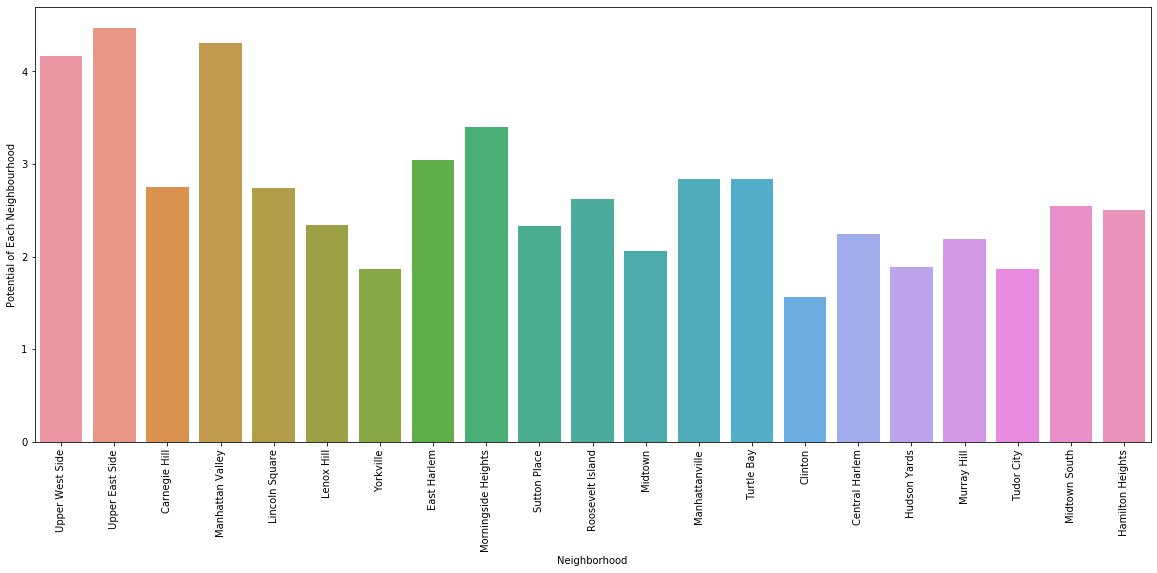

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
import seaborn as sns
sns.barplot(x=z2['Neighborhood'],y=5/((z2['NormDist']+1)*(z2['NormGym']+1)))
plt.ylabel('Potential of Each Neighbourhood')
plt.xticks(rotation='vertical')

I believe this barchart further proves the inferences we made from the clusters obtained. We eliminate all the neighborhoods in cluster 0 and 1 fro low potential. The highest potential is seen in neighborhoods 
* Upper West Side
* Upper East side
* Manhattan Valley
* Morningside Heights
* East Harlem

These points belong to cluster 1 and are the ideal spots to generate maximum revenue. They have almost no preexisting gyms and are very close to the center of the city. Upper West Side mainly comprises of restaurants and delis. **Nothing here suggests any athletic activities take place in this locality**. Thus it can be eliminated. This is the issue with East Harlem as well.  

We can divide the remaining prospect neighborhoods into 2 categories. The first being neighborhoods that are close to the center and indicate athletic activities. Little to no gyms exist here. The neighborhoods are:
* Upper East Side
* Morningside Heights
* Manhattan Valley

One must keep in mind that these areas are expensive. Upper east side and Manhattan Valley are the ideal places to set up the gym as Morningside Heights is a little further away. Personally I would suggest **Manhattan Valley** as the ideal location as it has Yoga centers as well as a spa. These services nicely complement a gym and will enhance revenue.

The next category is that of gyms that are further away from the center but will be cheaper to set up. The competition is also higher in this category. The neighborhoods here are:
* Carnegie Hill
* Lincoln Square
* Manhattanville
* Sutton Place
* Turtle Bay

The barchart suggests that **Manhattanville and Turtle Bay** both are good prospects. Carnegie Hill and Lincoln square are a tad bit overcrowded with gyms and Sutton Place is too far from the center of Manhattan.
There exists parks in both these regions which will help with customer traffic.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify a suitable location for stakeholders looking to set up a gym. Through the application of clustering and Foursquare API, I have identified the best neighborhoods for this project. They are
* Manhattan Valley
* Upper East Side
* Manhattanville
* Turtle Bay

Manhattan Valley would require higher capital but would generate the maximum revenue. It is the closest to the center and has complementary businesses. Upper East Side is a good prospect as well but will be even more expensive. Manhattanville and Turtle Bay are ideal prospects for stakeholders who would not wish to play the excessive charges of location. The competition in this region is higher as most gym owners would prefer this region. 

The final decision would ultimately depend on the stakeholder and the budget he/she has. Personal preference will play a big role as well in determining the best location.